# Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения #

# Imports

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as O

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

print('Версия TensoFlow =', tf.__version__)
print('Версия Keras =', keras.__version__)

Версия TensoFlow = 2.10.0
Версия Keras = 2.10.0


# Загрузка данных

In [2]:
# Читаем данные из файла
df = pd.read_csv('..\data\ebw_data.csv')

In [3]:
df.head(5)

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


- **IW** - величина сварочного тока;

- **IF** - ток фокусировки электронного пучка;

- **VW** - скорость сварки;

- **FP** - Менялось расстояние от поверхности образцов до электронно-оптической системы. 

# EDA

In [4]:
# Проверим пропуски
df.isna().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

In [5]:
# Общая информация о датасете
df.describe()

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


Text(0, 0.5, 'Width')

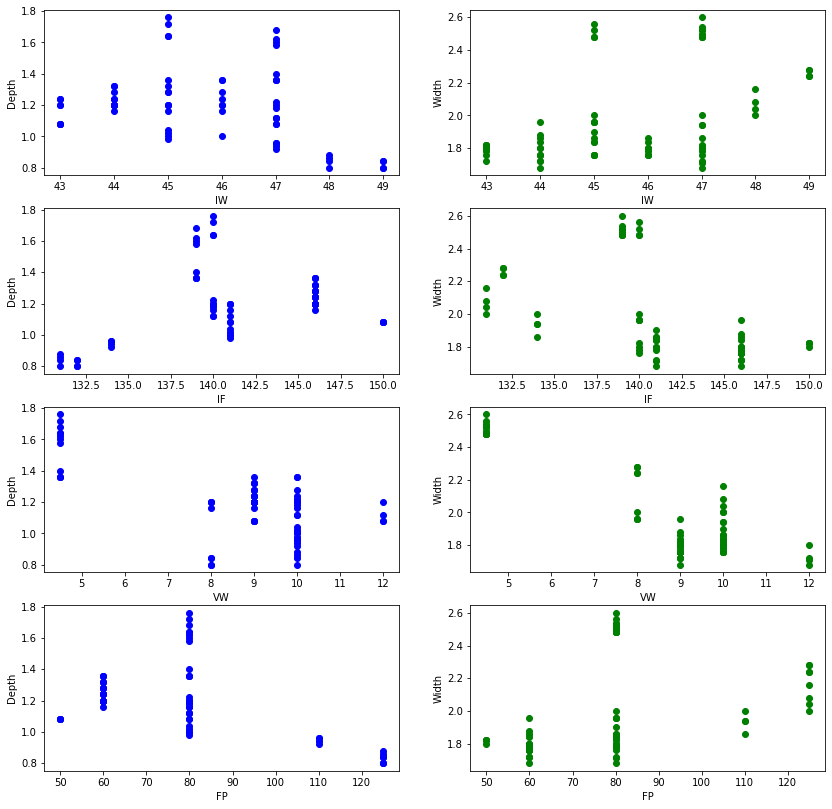

In [6]:
# Построим графики зависимости глубины и ширины от каждой переменной (IW, IF, VW, FP)
fig = plt.figure(figsize=[14, 14])

ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)
ax4 = fig.add_subplot(424)
ax5 = fig.add_subplot(425)
ax6 = fig.add_subplot(426)
ax7 = fig.add_subplot(427)
ax8 = fig.add_subplot(428)

ax1.scatter(df['IW'], df['Depth'], color='b')
ax1.set_xlabel('IW'); ax1.set_ylabel('Depth')
ax2.scatter(df['IW'], df['Width'], color='g')
ax2.set_xlabel('IW'); ax2.set_ylabel('Width')

ax3.scatter(df['IF'], df['Depth'], color='b')
ax3.set_xlabel('IF'); ax3.set_ylabel('Depth')
ax4.scatter(df['IF'], df['Width'], color='g')
ax4.set_xlabel('IF'); ax4.set_ylabel('Width')

ax5.scatter(df['VW'], df['Depth'], color='b')
ax5.set_xlabel('VW'); ax5.set_ylabel('Depth')
ax6.scatter(df['VW'], df['Width'], color='g')
ax6.set_xlabel('VW'); ax6.set_ylabel('Width')

ax7.scatter(df['FP'], df['Depth'], color='b')
ax7.set_xlabel('FP'); ax7.set_ylabel('Depth')
ax8.scatter(df['FP'], df['Width'], color='g')
ax8.set_xlabel('FP'); ax8.set_ylabel('Width')


Text(0, 0.5, 'Width')

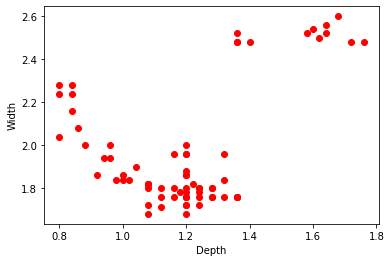

In [7]:
# А также график как выглядит ширина от глубины
fig = plt.figure()
plt.scatter(df['Depth'], df['Width'], color='r')
plt.xlabel('Depth'); plt.ylabel('Width')

<AxesSubplot:>

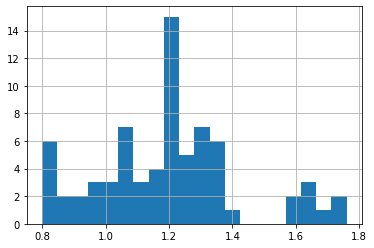

In [8]:
df['Depth'].hist(bins=20)

<AxesSubplot:>

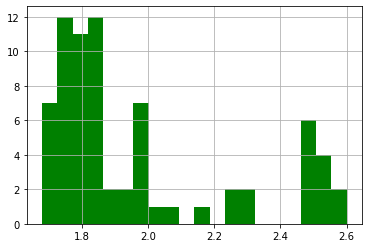

In [9]:
df['Width'].hist(bins=20, color='g')

**Вывод:** кажется, что имеются выбросы в данных. Значения глубины большие 1.6, а также значения ширины большие 2.4 явно выбиваются из общей картины остальных значений. Удалим их и построим графики заново.

In [10]:
df_backup = df.copy()
df = df[(df['Depth'] <= 1.6) & (df['Width'] <= 2.4 )]

Text(0, 0.5, 'Width')

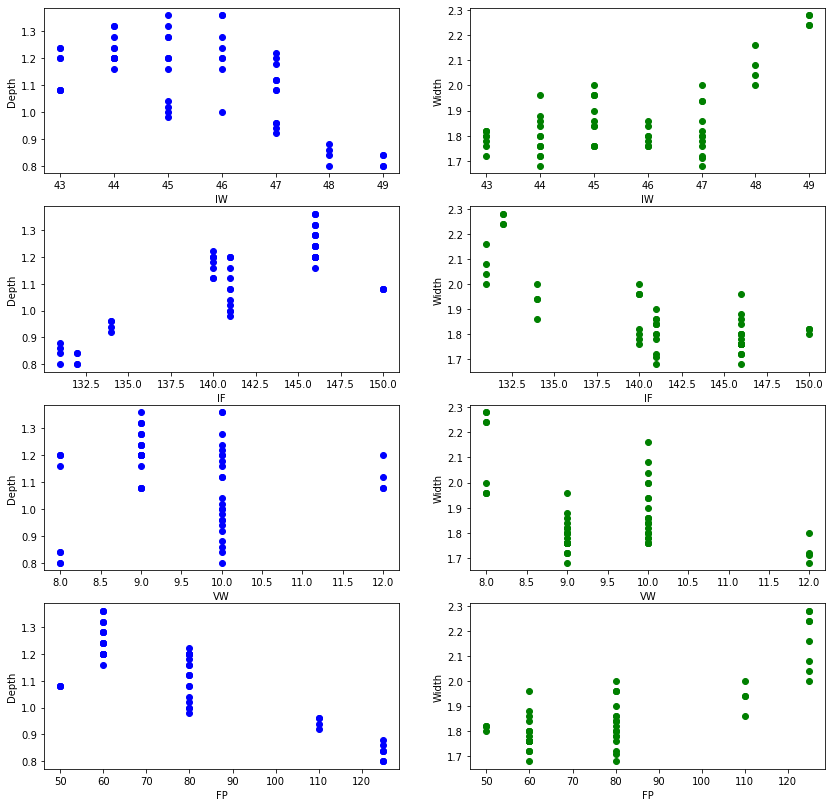

In [11]:
fig = plt.figure(figsize=[14, 14])

ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)
ax4 = fig.add_subplot(424)
ax5 = fig.add_subplot(425)
ax6 = fig.add_subplot(426)
ax7 = fig.add_subplot(427)
ax8 = fig.add_subplot(428)

ax1.scatter(df['IW'], df['Depth'], color='b')
ax1.set_xlabel('IW'); ax1.set_ylabel('Depth')
ax2.scatter(df['IW'], df['Width'], color='g')
ax2.set_xlabel('IW'); ax2.set_ylabel('Width')

ax3.scatter(df['IF'], df['Depth'], color='b')
ax3.set_xlabel('IF'); ax3.set_ylabel('Depth')
ax4.scatter(df['IF'], df['Width'], color='g')
ax4.set_xlabel('IF'); ax4.set_ylabel('Width')

ax5.scatter(df['VW'], df['Depth'], color='b')
ax5.set_xlabel('VW'); ax5.set_ylabel('Depth')
ax6.scatter(df['VW'], df['Width'], color='g')
ax6.set_xlabel('VW'); ax6.set_ylabel('Width')

ax7.scatter(df['FP'], df['Depth'], color='b')
ax7.set_xlabel('FP'); ax7.set_ylabel('Depth')
ax8.scatter(df['FP'], df['Width'], color='g')
ax8.set_xlabel('FP'); ax8.set_ylabel('Width')


Text(0, 0.5, 'Width')

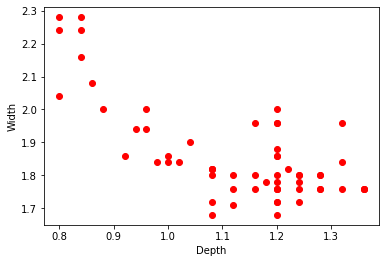

In [12]:
fig = plt.figure()
plt.scatter(df['Depth'], df['Width'], color='r')
plt.xlabel('Depth'); plt.ylabel('Width')

<AxesSubplot:>

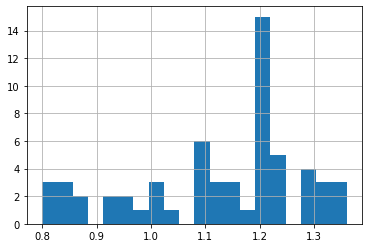

In [13]:
df['Depth'].hist(bins=20)

<AxesSubplot:>

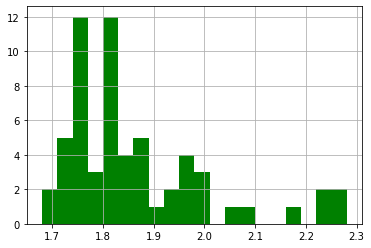

In [14]:
df['Width'].hist(bins=20, color='g')

**Вывод:** После удаления выбросных значений, стала просматриваться определенная тенденция и зависимость одной переменной от другой. Оставляем датасет с таком виде и приступим к моделированию.

# Modeling

In [15]:
y_depth = df['Depth']
y_width = df['Width']
X = df.drop(['Depth', 'Width'], axis=1)

In [16]:
# Разбиваем датасет на тренировочную и тестовую выборки
X_train, X_test, y_d_train, y_d_test = train_test_split(X, y_depth, test_size=0.2, random_state=42)

In [17]:
# Разбиваем датасет на тренировочную и тестовую выборки
X_train, X_test, y_w_train, y_w_test = train_test_split(X, y_width, test_size=0.2, random_state=42)

In [18]:
# оптимизатор GridSearch
def grid_optimizer(model, X, y, param_grids):
    gs = GridSearchCV(model, 
                      param_grid=param_grids, 
                      cv=5, 
                      scoring='neg_mean_squared_error')
    gs.fit(X, y)
    print(f"Best MSE-score: {gs.best_score_}")
    print(f"Best params: {gs.best_params_}")
    return gs.best_estimator_

In [19]:
# Использует Стандарную нормализацию
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# Получаем значения стандартного нормализатора для дальнейшего использовании в веб-приложении. 
scaler.scale_, scaler.mean_, scaler.var_, scaler.n_features_in_, scaler.n_samples_seen_


(array([ 1.78815062,  5.86387096,  0.88755868, 24.902588  ]),
 array([ 45.72916667, 141.10416667,   9.4375    ,  80.83333333]),
 array([  3.19748264,  34.38498264,   0.78776042, 620.13888889]),
 4,
 48)

Будем моделировать 3 модели (RidgeRegression, RandomForestRegressor, NeuralNetwork) для сравнения. Будем строить отдельную модель для каждого таргера Depth/Width, кроме в нейросетевой модели, т.к. там можно прогнозировать сразу оба таргета.

## 1. RidgeRegression

### a) Model for depth prediction

In [21]:
r_d = Ridge(random_state=42)

In [22]:
param_grid = {
    'alpha': [0.2, 0.5, 0.8, 1],
    'solver': ['auto', 'lbfgs', 'saga'],
}

In [23]:
best_r_d = grid_optimizer(r_d, X_train, y_d_train, param_grid)

Best MSE-score: -0.005419350024416884
Best params: {'alpha': 0.2, 'solver': 'auto'}


In [24]:
y_d_pred = best_r_d.predict(X_test)
print(f'RidgeRegression MSE-score: {mean_squared_error(y_d_test, y_d_pred)}')

RidgeRegression MSE-score: 0.002336038909558509


### b) Model for width prediction

In [25]:
r_w = Ridge(random_state=42)

In [26]:
param_grid = {
    'alpha': [0.2, 0.5, 0.8, 1],
    'solver': ['auto', 'lbfgs', 'saga'],
}

In [27]:
best_r_w = grid_optimizer(r_w, X_train, y_w_train, param_grid)

Best MSE-score: -0.0033714790312116627
Best params: {'alpha': 0.2, 'solver': 'auto'}


In [28]:
y_w_pred = best_r_w.predict(X_test)
print(f'RidgeRegression MSE-score: {mean_squared_error(y_w_test, y_w_pred)}')

RidgeRegression MSE-score: 0.0024851932507651835


## 2. RandomForestRegression

### a) Model for depth prediction

In [29]:
rfr_d = RandomForestRegressor(random_state=42, n_jobs=-1)

In [30]:
param_grid = {
    'n_estimators': [20, 100, 250, 1000],
    'max_depth': [5, 8, 10, 15],
    'max_features': ['sqrt', 4],
}

In [31]:
best_rfr_d = grid_optimizer(rfr_d, X_train, y_d_train, param_grid)

Best MSE-score: -0.0030052597949295047
Best params: {'max_depth': 5, 'max_features': 4, 'n_estimators': 100}


In [32]:
y_d_pred = best_rfr_d.predict(X_test)
print(f'RandomForestRegression MSE-score: {mean_squared_error(y_d_test, y_d_pred)}')

RandomForestRegression MSE-score: 0.0015718977565485402


### b) Model for width prediction

In [33]:
rfr_w = RandomForestRegressor(random_state=42, n_jobs=-1)

In [34]:
param_grid = {
    'n_estimators': [20, 100, 250, 1000],
    'max_depth': [5, 8, 10, 15],
    'max_features': ['sqrt', 4],
}

In [35]:
best_rfr_w = grid_optimizer(rfr_w, X_train, y_w_train, param_grid)

Best MSE-score: -0.0034378155506557167
Best params: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 20}


In [36]:
y_w_pred = best_rfr_w.predict(X_test)
print(f'RandomForestRegression MSE-score: {mean_squared_error(y_w_test, y_w_pred)}')

RandomForestRegression MSE-score: 0.003314756937546659


## 3. Neural Network

In [37]:
y_train = pd.concat([y_d_train, y_w_train], axis=1)
y_test = pd.concat([y_d_test, y_w_test], axis=1)

In [38]:
y_d_train.iloc[22], y_w_train.iloc[22]

(1.16, 1.8)

In [39]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [40]:
y_train[22]

array([1.16, 1.8 ])

In [41]:
K.clear_session()

In [42]:
# Модель простого перцептрона, после некоторых итераций моделирования данная глубина нейронной модели показала лучшую метрику MSE.
# Батч-нормализация и Дроп-ауты не привели к улучшению качества, вероятно из-за небольшого датасета - нейросетевая модель не могла с такими сильными "штрафами" показать хорошее обобщение данных.
nn_model = Sequential()
nn_model.add(Dense(6, activation='elu', input_shape=(4,)))
nn_model.add(Dense(8, activation='elu'))
nn_model.add(Dense(10, activation='elu'))
nn_model.add(Dense(8, activation='elu'))
nn_model.add(Dense(4, activation='elu'))
nn_model.add(Dense(2))
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 30        
                                                                 
 dense_1 (Dense)             (None, 8)                 56        
                                                                 
 dense_2 (Dense)             (None, 10)                90        
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 dense_4 (Dense)             (None, 4)                 36        
                                                                 
 dense_5 (Dense)             (None, 2)                 10        
                                                                 
Total params: 310
Trainable params: 310
Non-trainable pa

In [43]:
# Компилируем модель ИНС
BATCH_SIZE = 4
EPOCHS = 100

nn_model.compile(
  loss='mse', 
  optimizer=O.RMSprop(learning_rate=0.01),
  metrics=['mean_squared_error']
)


In [44]:
# добавляем некоторые колл-бэки
checkpoint = ModelCheckpoint("../model/best_model.hdf5" , monitor = ['val_mean_squared_error'] , verbose = 1  , mode = 'min')
earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=10, restore_best_weights=True)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.5, min_lr=1e-7, patience=3, verbose=1)
callbacks_list = [checkpoint, earlystop, callback_reduce_lr]

In [45]:
# обучаем
history = nn_model.fit(
  X_train, y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=(X_test, y_test),
  shuffle=False,
  callbacks=callbacks_list
)


Epoch 1/100
 1/12 [=>............................] - ETA: 9s - loss: 3.0425 - mean_squared_error: 3.0425
Epoch 1: saving model to ../model\best_model.hdf5
12/12 [==============================] - 1s 22ms/step - loss: 0.9599 - mean_squared_error: 0.9599 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - lr: 0.0100
Epoch 2/100
 1/12 [=>............................] - ETA: 0s - loss: 0.1127 - mean_squared_error: 0.1127
Epoch 2: saving model to ../model\best_model.hdf5
12/12 [==============================] - 0s 6ms/step - loss: 0.0348 - mean_squared_error: 0.0348 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - lr: 0.0100
Epoch 3/100
 1/12 [=>............................] - ETA: 0s - loss: 0.0198 - mean_squared_error: 0.0198
Epoch 3: saving model to ../model\best_model.hdf5
12/12 [==============================] - 0s 6ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - lr: 0.0100
Epoch 4/100
 1/12 [=>...........................

 1/12 [=>............................] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 26: saving model to ../model\best_model.hdf5
12/12 [==============================] - 0s 5ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - lr: 0.0025
Epoch 27/100
 1/12 [=>............................] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 27: saving model to ../model\best_model.hdf5

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
12/12 [==============================] - 0s 5ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - lr: 0.0025
Epoch 28/100
 1/12 [=>............................] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 28: saving model to ../model\best_model.hdf5
12/12 [==============================] - 0s 5ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0024 - val_mean_squared_error

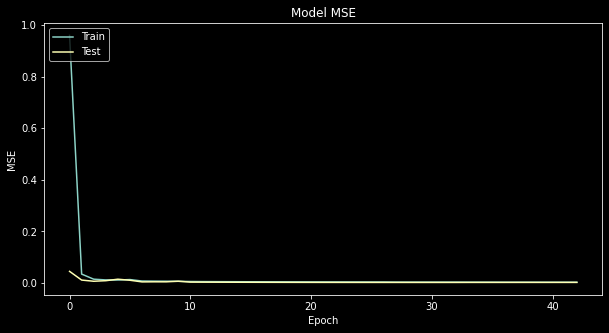

In [46]:
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Сравнение моделей

In [47]:
# True value
y_test

array([[1.2 , 2.  ],
       [1.02, 1.84],
       [1.28, 1.8 ],
       [1.2 , 1.86],
       [1.08, 1.68],
       [1.24, 1.72],
       [1.36, 1.76],
       [1.2 , 1.76],
       [1.12, 1.71],
       [1.28, 1.76],
       [1.2 , 1.88],
       [1.2 , 1.72]])

In [48]:
# RandomForest
rfr_pred = np.array((best_rfr_d.predict(X_test), best_rfr_w.predict(X_test))).T
rfr_pred.round(decimals=2)

array([[1.18, 1.96],
       [1.01, 1.86],
       [1.23, 1.78],
       [1.23, 1.78],
       [1.14, 1.77],
       [1.23, 1.78],
       [1.29, 1.77],
       [1.24, 1.79],
       [1.14, 1.77],
       [1.32, 1.77],
       [1.23, 1.78],
       [1.24, 1.79]])

In [49]:
print(f'MSE RandomForest: {((rfr_pred - y_test) ** 2).mean()}')

MSE RandomForest: 0.002443327347047597


In [50]:
# Neural Network
nn_pred = nn_model.predict(X_test)
nn_pred.round(decimals=2)

1/1 [==============================] - 0s 92ms/step


array([[1.19, 1.95],
       [1.06, 1.83],
       [1.22, 1.79],
       [1.22, 1.79],
       [1.12, 1.77],
       [1.22, 1.79],
       [1.29, 1.76],
       [1.17, 1.8 ],
       [1.12, 1.77],
       [1.27, 1.79],
       [1.22, 1.79],
       [1.17, 1.8 ]], dtype=float32)

In [51]:
print(f'MSE NeuralNetwork: {((nn_pred - y_test) ** 2).mean()}')

MSE NeuralNetwork: 0.002349276074771881


**Вывод:** нейросетевая модель всё-таки показала чуть лучший результат по метрики MSE. Поэтому сохраняем её и выводим в продакшн.

**P.S.**: если не удалять "выбросы" все модели показывают худшие результаты...